Cargué el archivo de Calificaciones.csv usando la libreria pandas. Con df.dtypes verificas los tipos de variables, ya que es fundamental conocer si las columnas son numéricas o categóricas antes de aplicar transformaciones y modelos

In [182]:
import pandas as pd
import numpy as np
from seaborn import heatmap
import seaborn as sns

df = pd.read_csv("Calificaciones.csv")
print(df.shape)
print(df.columns)
print(df.head())
print(df.dtypes)

(395, 10)
Index(['Escuela', 'Sexo', 'Edad', 'HorasDeEstudio', 'Reprobadas', 'Internet',
       'Faltas', 'G1', 'G2', 'G3'],
      dtype='object')
  Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10
Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


convierto variables categóricas en variables dummy mediante pd.get_dummies(). Esto lo hice para las columnas Escuela, Sexo, Internet y HorasDeEstudio. Aunque HorasDeEstudio esta codificada con números (1,2,3,4), en realidad representa categorias rangos de horas, por lo que tambien la trasnforme a variables dummy. Elimine las columnas originales y mandtuve unicamente las nuevas variables numéricas, lo que es necesario porque los modelos de regresión lineal múltiple no pueden trabajar con variables categóricas sin codificar

In [183]:
dummyEscuela = pd.get_dummies(df["Escuela"],drop_first=True)
print("Valores de Escuela: \n", df["Escuela"].value_counts())

dummySexo = pd.get_dummies(df["Sexo"], drop_first=True)
print("Valores de Sexo: \n", df["Sexo"].value_counts())

dummyInternet = pd.get_dummies(df["Internet"], drop_first=True)
print("Valores de Internet: \n", df["Internet"].value_counts())

dummyHoras = pd.get_dummies(df["HorasDeEstudio"], drop_first=True)
print("Valores de Horas de Estudio: \n", df["HorasDeEstudio"].value_counts())

df_mod = pd.concat([df, dummyEscuela, dummySexo, dummyInternet, dummyHoras], axis=1)
df_mod = df_mod.drop(columns=["Escuela", "Sexo", "Internet", "HorasDeEstudio"])
df_mod.head()

Valores de Escuela: 
 Escuela
GP    349
MS     46
Name: count, dtype: int64
Valores de Sexo: 
 Sexo
F    208
M    187
Name: count, dtype: int64
Valores de Internet: 
 Internet
yes    329
no      66
Name: count, dtype: int64
Valores de Horas de Estudio: 
 HorasDeEstudio
2    198
1    105
3     65
4     27
Name: count, dtype: int64


,Edad,Reprobadas,Faltas,G1,G2,G3,MS,M,yes,2,3,4
0,18,0,6,5,6,6,False,False,False,True,False,False
1,17,0,4,5,5,6,False,False,True,True,False,False
2,15,3,10,7,8,10,False,False,True,True,False,False
3,15,0,2,15,14,15,False,False,True,False,True,False
4,16,0,4,6,10,10,False,False,False,True,False,False


Hice el motodo de Tukey con k=3 para detectar outliers en la variable Faltas. Este metodo se basas en el rango intercuartilico iqr y es apropiado para detectara valores extremos sin suponer que los datos son normales. Se muestra los registros considerados atipicos y despues los elimine con df.drop(). La decision de eliminarlos se justifica porque valores de faltas extremadamente grandes distorsionan la regresión y generar un modelo menos confiable.

In [184]:
q1 = df.Faltas.quantile(0.25)
q3 = df.Faltas.quantile(0.75)
iqr = q3-q1
li = q1 - (3*iqr)
ls = q3 + (3*iqr)
out=np.where((df.Faltas<=li) | (df.Faltas>=ls))[0]
print(df.iloc[out,:])
df = df.drop(index=out)

    Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  \
74       GP    F    16               2           0      yes      54  11  12   
183      GP    F    17               2           0      yes      56   9   9   
276      GP    F    18               2           0      yes      75  10   9   
307      GP    M    19               1           1      yes      38   8   9   
315      GP    F    19               3           1      yes      40  13  11   

     G3  
74   11  
183   8  
276   9  
307   8  
315  11  


Generé una matriz de correlación y la representé gráficamente con un heatmap utilizando seaborn. La correlación mide la fuerza y dirección de la relación lineal entre dos variables numéricas, con valores que van de -1 a 1.
Cercano a 1: fuerte correlacion positiva(cuando una variable aumenta, laa otra también).
Cercano a -1: fuerte correlación negativa (cuando una variable aumenta, la otra tiende a disminuir).
Cercano a 0: poco o nula relación lineal.

Este analisis es importante porque la regresión lineal múltiple supone que los predictores no estan fuertemente correlacionados entre si. Cuando dos o mas vairables indpendientes presentan correlaciones muy altas, se produce el problema de multicolinealidad, que tiene varias consecuencias negativas, como puede llevar a que el modelo sea inestable, pequeños cambios en los datos generan grandes cambios en los coeficientes. En este conjuno de datos era esperable que las calificaciones G1 y G2 estén muy correlacionadas con G3(calificacion final), ya que son mediciones del mismo rendimiento académico en distintos periodos. También es imporante revisar si G1 y G2 estan correlacionadas entre si. 

El heatmap ayuda a la detección de estos patrones de correlación porque utiliza una esscala de colores, lo que permite identificar rápidamente qué variables presentan posibles problemas de colinealidad.

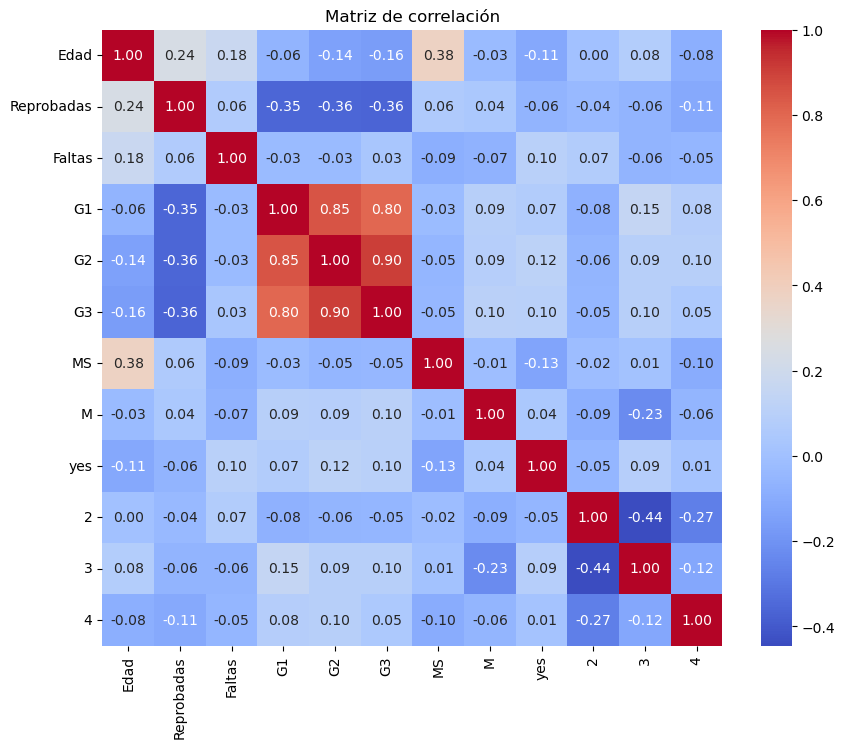

In [185]:
corr = df_mod.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Agregue dos variables de interacción, G1 x G2, porque intuitivamente las calificaciones de los dos primeros periodos pueden tener un efecto combinado en la calificación final. Edad x Faltas, porque la relación entre la edad del estudiante y sus inasistencias podria influir de manera conjunata en el rendimiento académico. el objetivo fue si estas interacciones permiten al modelo capturar relaciones más complejas que no se reflejan únicamente en los efectos individuales.

In [190]:
df_mod["Interaccion_G1_G2"] = df_mod["G1"] * df_mod["G2"]
df_mod["Iteraccion_Edad_Faltas"] = df_mod["Edad"] * df_mod["Faltas"]
print(df_mod.head())

   Edad  Reprobadas  Faltas  G1  G2  G3     MS      M    yes      2      3  \
0    18           0       6   5   6   6  False  False  False   True  False   
1    17           0       4   5   5   6  False  False   True   True  False   
2    15           3      10   7   8  10  False  False   True   True  False   
3    15           0       2  15  14  15  False  False   True  False   True   
4    16           0       4   6  10  10  False  False  False   True  False   

       4  Interaccion_G1_G2  Iteraccion_Edad_Faltas  
0  False                 30                     108  
1  False                 25                      68  
2  False                 56                     150  
3  False                210                      30  
4  False                 60                      64  


Use el modelo de regresión lineal múltiple (OLS) usando un 80% de los datos para entrenamiento y un 20% para prueba. Agregue una constante con sm.add_constant para considerar el término independiente. El resumen del modelo model.summary() muestra los coeficientes, significancia estadistica y metricas de ajuste como el R². Hice predicciones en el conjunto de prueba y generé una gráfica de dispersión de valores reales vs predichos. La interpretacion es mientras mas cercanos estén los puntos a línea discontinua de identidad, mejor es la capacidad predictiva del modelo. Esto permite evaluar visualmente si el modelo generaliza bien.

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     150.4
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          6.77e-116
Time:                        00:04:13   Log-Likelihood:                -633.57
No. Observations:                 316   AIC:                             1291.
Df Residuals:                     304   BIC:                             1336.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0156      1.585      0.641      0.5

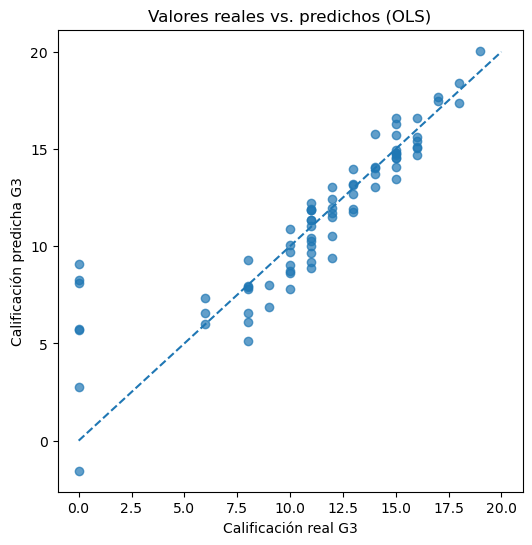

Conclusión: mientras más se acerquen los puntos a la línea discontinua, mejor el desempeño del modelo.


In [189]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

x = df_mod.drop(columns=["G3"]).apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(df_mod["G3"], errors="coerce")

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=55
)

x_train_const = sm.add_constant(x_train, has_constant="add")
model = sm.OLS(y_train.astype(float), x_train_const.astype(float)).fit()
print(model.summary())

x_test_const = sm.add_constant(x_test, has_constant="add")
y_pred = model.predict(x_test_const.astype(float))

print("Tamaño y_test:", len(y_test), " | Tamaño y_pred:", len(y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = y.min(), y.max()
plt.plot([mn, mx], [mn, mx], linestyle="--") 
plt.xlabel("Calificación real G3")
plt.ylabel("Calificación predicha G3")
plt.title("Valores reales vs. predichos (OLS)")
plt.show()

print("Conclusión: mientras más se acerquen los puntos a la línea discontinua, mejor el desempeño del modelo.")